TODO
* Work more on classification model

In [ ]:
FILE_DIR = "example_dir/Data/Datasets"
classification = True
rate = True
low_thres = False #(True -> .1/yr, False --> .2/yr)

# Import Dataset

## Imports

In [ ]:
import os
import pandas as pd
from google.colab import drive
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from imblearn.metrics import geometric_mean_score
import matplotlib.pyplot as plt, matplotlib.ticker as mticker

torch.manual_seed(123)

In [ ]:
drive.mount('/content/drive')

## Load correct file

In [ ]:
if classification:
  if not rate:
    dataset_dir = os.path.join(FILE_DIR, "post_con_change_classification_2022-04-13 23:13:29.csv")
    y_col = 'Categorical Unidimensional Change'
  elif not low_thres:
    dataset_dir = os.path.join(FILE_DIR, "post_con_rate_classification_2022-04-13 23:13:29.csv")
    y_col = 'Categorical Unidimensional Rate'
  else:
    dataset_dir = os.path.join(FILE_DIR, "lower_thres_post_con_rate_classification_2022-04-13 23:14:55.csv")
    y_col = 'Categorical Unidimensional Rate'
else:
  if not rate:
    dataset_dir = os.path.join(FILE_DIR, "post_con_change_regression_2022-04-13 23:13:29.csv")
    y_col = 'Unidimensional Change'
  elif not low_thres:
    dataset_dir = os.path.join(FILE_DIR, "post_con_rate_regression_2022-04-13 23:13:29.csv")
    y_col = 'Unidimensional Rate'
  else:
    dataset_dir = os.path.join(FILE_DIR, "lower_thres_post_con_rate_regression_2022-04-13 23:14:55.csv")
    y_col = 'Unidimensional Rate'
print(y_col)

## Set X and Y of dataset

In [ ]:
df = pd.read_csv(dataset_dir)
x = df.drop(labels=y_col,axis=1)
y = df[y_col]

# if rate:
#   x = df.drop(labels='Unidimensional Rate',axis=1)
#   y = df['Unidimensional Rate']
# else:
#   x = df.drop(labels='Unidimensional Change',axis=1)
#   y = df['Unidimensional Change']

In [ ]:
print(x.shape)

(23, 394)


## Convert pandas array to tensor

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, scale_data=True):
    # if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
    X = X.copy()
    # if scale_data:
    #   scaler = StandardScaler()
    #   X[X.columns] = scaler.fit_transform(X[X.columns])
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
      X = X.to_numpy()
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
      y = y.to_numpy()
    self.num_pos = sum(y)
    self.num_neg = len(y) - self.num_pos
    self.X = torch.from_numpy(X)
    self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

# Create data Dataset object
data = Dataset(x, y, scale_data=False)

## Create Dataloader

In [ ]:
def get_data_loader(X, y, training = True, scale_data = True):
    """
    INPUT: 
        An optional boolean argument (default value is True for training dataset)

    RETURNS:
        Dataloader for the training set (if training = True) or the test set (if training = False)
    """
    # custom_transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    # train_set=datasets.FashionMNIST('./data',train=True, download=True,transform=custom_transform)
    # test_set=datasets.FashionMNIST('./data', train=False, transform=custom_transform)
    
    X = X.copy()

    if scale_data:
      scaler = StandardScaler()
      X[X.columns] = scaler.fit_transform(X[X.columns])

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

    # print(f"x train: {len(X_train)} x test:{len(X_test)} y train:{len(y_train)} y test: {len(y_test)}")
    # data_set = train_set if training else test_set

    if training:
      data_set = Dataset(X_train, y_train, scale_data=False)
      return torch.utils.data.DataLoader(data_set, batch_size = 16)
    else:
      data_set = Dataset(X_test, y_test, scale_data=False)
      return torch.utils.data.DataLoader(data_set, batch_size = 10000)

# Model

## Create Model

In [ ]:
def create_model(X, classification = False):
  # https://stackoverflow.com/questions/49008074/how-to-create-a-neural-network-for-regression
  # https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8
  if not classification:
    model = nn.Sequential(
        nn.Linear(train_loader.dataset.X.shape[1], 128), #train_loader.dataset.X.size()[1] or len(x.columns)
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),   
        # nn.Linear(32, 10),
        # nn.ReLU(),   
        nn.Linear(32, 1),
    )
  else:
    model = nn.Sequential(
      nn.Linear(train_loader.dataset.X.shape[1], 128), #train_loader.dataset.X.size()[1] or len(x.columns)
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),   
      nn.Linear(32, 1),
      nn.Sigmoid(),
  )
  return model

# Train Model

### Regression


In [ ]:
def train_model(model, train_loader, criterion, T):
    """

    INPUT: 
        model - the model produced by the previous function
        train_loader  - the train DataLoader produced by the first function
        criterion   - cross-entropy 
        T - number of epochs for training

    RETURNS:
        None
    """
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()

    for epoch in range(T):  # loop over the dataset multiple times
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(train_loader):
            inputs, targets = data
            # print(inputs, targets)
            inputs, targets = inputs.float(), targets.float()
            # print(type(inputs))
            # print(type(targets))
            # inputs, labels = inputs.Double(), targets.Double()

            optimizer.zero_grad()
            outputs = model(inputs)

            # print(outputs)

            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # print(running_loss)
            # running_loss = 0.0
            
            running_loss += loss.item()
            if i % 10 == 0:
                print(f'Epoch {epoch+1} mini-batch {i}: {running_loss}')
                # running_loss = 0.0
        # print(running_loss)
            # correct += outputs.argmax(dim=1).eq(labels).sum().item()
        # print(f'Train Epoch: {epoch} Accuracy: {correct}/{len(train_loader.dataset)} ({correct/len(train_loader.dataset)*100:.2f}%) Loss: {running_loss / len(train_loader):.3f}')
        # print(f"Train Epoch: {epoch} Loss: {running_loss / len(train_loader):.3f}")


if not classification:
  # criterion = nn.CrossEntropyLoss()
  criterion = nn.MSELoss()
  # criterion = nn.L1Loss()
  # train_loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True, num_workers=1) # Look into these parameters
  train_loader = get_data_loader(x,y)
  model = create_model(train_loader.dataset.X)
  train_model(model, train_loader, criterion, 32)

### Classification

In [ ]:
def train_model(model, train_loader, criterion, T):
    """

    INPUT: 
        model - the model produced by the previous function
        train_loader  - the train DataLoader produced by the first function
        criterion   - cross-entropy 
        T - number of epochs for training

    RETURNS:
        None
    """
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()

    for epoch in range(T):  # loop over the dataset multiple times
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(train_loader):
            inputs, targets = data
            # print(inputs, targets)
            inputs, targets = inputs.float(), targets.float()
            # print(type(inputs))
            # print(type(targets))
            # inputs, labels = inputs.Double(), targets.Double()

            optimizer.zero_grad()
            prob = model(inputs)
            # outputs = (prob>0.5).float()
            # print(targets)

            # print(outputs)

            loss = criterion(prob, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            # running_loss += loss.item()
            
            # print(running_loss)
            # running_loss = 0.0
            
            # running_loss += loss.item()
            # if i % 10 == 0:
            #     print(f'Epoch {epoch+1} mini-batch {i}: {running_loss}')
                # running_loss = 0.0
        # print(running_loss)
            # correct += outputs.argmax(dim=1).eq(labels).sum().item()
        # print(f'Train Epoch: {epoch} Accuracy: {correct}/{len(train_loader.dataset)} ({correct/len(train_loader.dataset)*100:.2f}%) Loss: {running_loss / len(train_loader):.3f}')
        # print(f"Train Epoch: {epoch} Loss: {running_loss / len(train_loader):.3f}")


if classification:
  criterion = nn.CrossEntropyLoss()
  # criterion = nn.L1Loss()
  # train_loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True, num_workers=1) # Look into these parameters
  train_loader = get_data_loader(x,y)
  weight = train_loader.dataset.num_pos/(train_loader.dataset.num_pos+train_loader.dataset.num_neg)
  print(weight)
  weights = torch.tensor([1-weight])
  # criterion = nn.CrossEntropyLoss(weight=weights)
  
  model = create_model(train_loader.dataset.X, classification=True)
  train_model(model, train_loader, criterion, 16)

# Model Evaluation

## Predict Test Set

In [ ]:
def predict_target(model, test_loader):
  pass
model.eval()
# predict_target
test_loader = get_data_loader(x, y, training=False)
x_test, y_test = iter(test_loader).next()

# y_test = y_test.tolist()

# Update once issues with tensor are fixed
y_pred = model(x_test.float())
if classification:
  y_pred = (y_pred>0.5).float()
y_pred = [p[0] for p in y_pred.tolist()]
print(y_pred)

[0.3788560628890991, 0.22266557812690735, 0.2686721384525299, 0.38566797971725464, 0.34748202562332153]


## Metrics

In [ ]:
# MSE = mean_squared_error(y_test, y_pred, squared=False)
# print(f"MSE: {MSE}")
if classification:
  f1 = f1_score(y_test, y_pred)
  acc = accuracy_score(y_test, y_pred)
  gmean = geometric_mean_score(y_test, y_pred)
  print(f"F1: {f1}")
  print(f"Accuracy: {acc}")
  print(f"Gmean: {gmean}")
else:
  RMSE = mean_squared_error(y_test, y_pred, squared=True)
  print(f"RMSE: {RMSE}")

## Plots and Figures

## Confusion Matrix

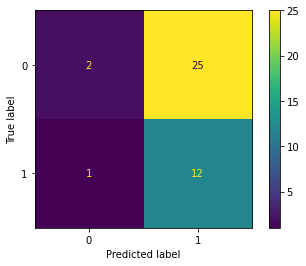

In [ ]:
if classification:
  cm = confusion_matrix(y_test,y_pred)
  # print(classification_report(y_test,y_pred))

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

### Growth Scatter Plot

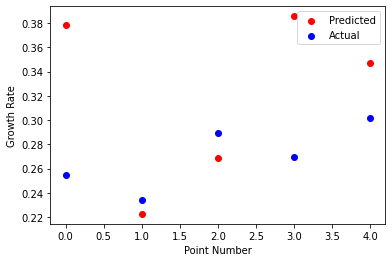

In [ ]:
if not classification:
  l = list(range(len(y_pred)))
  # ypred_vals = list(y_pred)
  # ytest_vals = list(y_test)

  plt.scatter(l, y_pred, color="red", label="Predicted")
  plt.scatter(l, y_test, color="blue", label="Actual")
  plt.xlabel("Point Number")
  if rate:
    plt.ylabel("Growth Rate")
  else:
    plt.ylabel("Growth")
  plt.legend(loc="upper right")

### Parity Plot

In [ ]:
# https://iphyer.github.io/blog/2020/02/24/ParityPlot/
if not classification:
  font_axis_publish = {
          'color':  'black',
          'weight': 'bold',
          'size': 18,
          }
  plt.rcParams['ytick.labelsize'] = 16
  plt.rcParams['xtick.labelsize'] = 16

  fignow = plt.figure(figsize=(8,8))
  bounds = (min(min(y_test), min(y_pred)) - int(0.1 * min(y_pred)), max(max(y_test), max(y_pred))+ int(0.1 * max(y_pred)))

  ax = plt.gca()
  ax.set_xlim(bounds)
  ax.set_ylim(bounds)
  ax.set_aspect("equal", "datalim")
  ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
  ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

  plt.plot(y_test, y_pred, "o", alpha=0.5, ms=10, markeredgewidth=0.0)
  ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

  plt.title("Parity Plot", fontdict=font_axis_publish)
  plt.xlabel('Ground Truth', fontdict=font_axis_publish)
  plt.ylabel('Prediction', fontdict=font_axis_publish)